<a href="https://colab.research.google.com/github/samuelfield/stock_trading_agent_RL/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Helpful Tutorials**

https://www.youtube.com/watch?v=gCJyVX98KJ4&t=700s (guys watch this its a step by step tutorial)


https://medium.freecodecamp.org/diving-deeper-into-reinforcement-learning-with-q-learning-c18d0db58efe

https://medium.freecodecamp.org/an-introduction-to-deep-q-learning-lets-play-doom-54d02d8017d8

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [0]:
# use this cell to install any modules we need
!pip install quandl

Because our state space is huge, we can't use Q-learning so we will use Deep-Q-learning.


**Our Model:**

1.   We take stock market information and our account information as input (money_in_account, stock1_price, stock2_price, stock1_shares_we_own, stock2_shares_we_own, etc)
2.   It outputs Q value for each actions (do_nothing, buy_stock1, buy_stock2, sell_stock1, sell_stock2, etc)

I can think of 2 limitations of this model:

1.   We can only take 1 action at a time (but that shouldn't be a problem if we continuously run our model).
2.   We can't specify how many shares to buy/sell (we can just assume we can only buy/sell X shares at once, then if our model wants to buy X shares of X stock. Then it just has to perform that action multiple times).

To make things simple, we should just assume that there are no overheads to buying and selling stocks other than the brokerage fee.

note: we should look into **policy gradient**, which is another approach to reinforcement learning which can handel contiuous action spaces which is more applicable to our problem



# **Training stock trading agent using Deep-Q learning**

## Import libraries

In [0]:
%matplotlib inline

import math
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import date
from calendar import monthrange
from collections import deque

# Intrinio dependencies
from http.client import HTTPSConnection
from base64 import b64encode
import json

# We gona use tensorflow instead of pytorch cuz tutorials are in tensorflow and its easier :v
import tensorflow as tf
import tensorflow.keras as k

from IPython import display
import quandl

random.seed()

## **Getting Training/Testing Data**

In [0]:
# Helper functions
def to_daily(monthly_data, target_dt):
    data = np.asarray(monthly_data)
    data_dt = monthly_data.reset_index()['Date']
    
    target_dt_rows = len(target_dt.index)
    data_dt_rows = len(data_dt.index)
    data_period = data_dt_rows/target_dt_rows # daily, monthly, quarterly
    daily_data = np.ndarray((target_dt_rows,1))
    j = 0
    
    for i in range(target_dt_rows):
        daily_data[i] = data[j]
        
        if ((data_period < 1) and ((i+1) < target_dt_rows) and ((j+1) < data_dt_rows)):
            target_combo = target_dt[i+1].year*100 + target_dt[i+1].month
            data_combo = data_dt[j+1].year*100 + data_dt[j+1].month
            
            if (target_combo >= data_combo):
                j += 1
                
        elif((data_period >= 1) and ((i+1) < target_dt_rows)): # Deal with daily data
            while (data_dt[j].day < target_dt[i+1].day):
                j += 1

    return daily_data

def preprocess_intrinio(data):
    total = 0
    for value in data['Value']:
        if (isinstance(value, int) or isinstance(value, float)):
            total += value
            
    avg = total / len(data['Value'])
    
    for i,value in enumerate(data['Value']):
        if (isinstance(value, str)):
            data['Value'][i] = avg
    
    return data
    

### Get data
train_dr = (2008,12,31,2016,1,1)
test_dr = (2016,1,1,2017,12,31)

train_start_date = str(train_dr[0]) + "-" + str(train_dr[1]) + "-" + str(train_dr[2])
train_end_date = str(train_dr[3]) + "-" + str(train_dr[4]) + "-" + str(train_dr[5])
test_start_date = str(test_dr[0]) + "-" + str(test_dr[1]) + "-"+ str(test_dr[2])
test_end_date = str(test_dr[3]) + "-" + str(test_dr[4]) + "-" + str(test_dr[5])

# TICKER LIST - Enter company stock tickers
ticker_list = ["AAPL","XOM","ATVI","GE","WMT"]

In [0]:
# Get QUANDL share price data
quandl.ApiConfig.api_key = "okx11Jz3Rb2m5hzDdS-x"
basic_params = ["Adj. Close", "Adj. Volume"]

# Get Intrinio share fundamentals (P/E, earnings, etc.)
fundamentals =  ['debttoequity','divpayoutratio','roe','freecashflow','netincomegrowth', 'arturnover' ,'operatingmargin']  

# Get Federal Reserve Economic Data (FRED) (Unemployment rate, interest rate, gdp, personal consumption, CPI, corporate profits)
fred_codes = ["UNRATE","GDP","PCE","CPIAUCSL","CP"] 

#This sets up the https connection
intrinio_url = "api.intrinio.com"
intrinio_api_key = "OmE5YTRmOTYxZDIyN2Q5ZTIwMWNhMGNmZjAyMWE4NjRh"
headers = { 'Authorization' : 'Bearer  %s' %  intrinio_api_key }
train_dates = '&start_date={}&end_date={}'.format(train_start_date, train_end_date)
test_dates = '&start_date={}&end_date={}'.format(test_start_date, test_end_date)

c = HTTPSConnection(intrinio_url)

all_train_data = []
all_test_data = []

for i, ticker in enumerate(ticker_list):
    # Pull stock price data from WIKI
    share_train_data = quandl.get("WIKI/" + ticker, start_date=train_start_date, end_date=train_end_date)
    share_test_data = quandl.get("WIKI/" + ticker, start_date=test_start_date, end_date=test_end_date)

    # Preprocess data by removing everything but "Adj. Close" and "Adj. Volume"
    share_train_data.drop(["Open", "High", "Low", "Close", "Volume", "Ex-Dividend","Split Ratio", "Adj. Open", "Adj. High","Adj. Low"], axis=1, inplace=True)
    share_test_data.drop(["Open", "High", "Low", "Close", "Volume", "Ex-Dividend","Split Ratio", "Adj. Open", "Adj. High","Adj. Low"], axis=1, inplace=True)

    # Get the date time patterns for filling in other attributes
    if (i == 0):
        train_datetime = share_train_data.reset_index()['Date']
        test_datetime = share_test_data.reset_index()['Date']
        
    # On first iteration, Initialize train and test arrays to data from first stock
    share_train_data = share_train_data[0:len(train_datetime)]
    share_test_data = share_test_data[0:len(train_datetime)]
    
    train_data = share_train_data[0:len(train_datetime)]
    test_data = share_test_data[0:len(test_datetime)]

    for fundamental in fundamentals:
        pnumber = 1
        more_pages = True
        # Get training data
        while(more_pages == True):
            url_suffix = '/historical_data?type=QTR&page_number='+ str(pnumber) +'&identifier='+ticker+'&item='+fundamental+train_dates
            c.request('GET', url_suffix, headers=headers)

            # Read response
            res = c.getresponse()
            json_data = res.read()

            # Convert json to Python dict object.
            data_dict = json.loads(json_data)
            if (pnumber == data_dict['total_pages']):
                more_pages = False
            if (pnumber==1):
                share_train_data = pd.DataFrame(data_dict['data'])
            else:
                share_train_data = share_train_data.append(data_dict['data'])
            pnumber += 1
        
        share_train_data.columns = ['Date','Value']
        share_train_data['Date'] = pd.to_datetime(share_train_data['Date'])
        share_train_data.set_index('Date',inplace=True, drop=True)
        share_train_data = share_train_data.sort_index(ascending=True)
        share_train_data = preprocess_intrinio(share_train_data)
        share_train_data = to_daily(share_train_data, train_datetime)
        
        train_data = np.append(train_data, share_train_data, axis=1)
            
        # Get testing data
        url_suffix = '/historical_data?identifier='+ticker+'&item='+fundamental+test_dates
        c.request('GET', url_suffix, headers=headers)

        # Read response
        res = c.getresponse()
        json_data = res.read()

        # Convert json to Python dict object.
        data_dict = json.loads(json_data)
        share_test_data = pd.DataFrame(data_dict['data'])
        share_test_data.columns = ['Date','Value']
        share_test_data['Date'] = pd.to_datetime(share_test_data['Date'])
        share_test_data.set_index('Date',inplace=True, drop=True)
        share_test_data = share_test_data.sort_index(ascending=True)
        share_test_data = to_daily(share_test_data, test_datetime)

        test_data = np.append(test_data, share_test_data, axis=1)
       
    for i, code in enumerate(fred_codes):
        # Pull econ data from FRED
        econ_train_data = quandl.get('FRED/' + code, start_date=train_start_date, end_date=train_end_date)
        econ_test_data = quandl.get('FRED/' + code, start_date=test_start_date, end_date=test_end_date)

        econ_train_data = to_daily(econ_train_data, train_datetime)
        econ_test_data = to_daily(econ_test_data, test_datetime)
        
        train_data = np.append(train_data, econ_train_data, axis=1)
        test_data = np.append(test_data, econ_test_data, axis=1)
        
    all_train_data.append(train_data)
    all_test_data.append(test_data)

all_train_data = np.asarray(all_train_data)
all_test_data = np.asarray(all_test_data)
print(all_train_data.shape, all_test_data.shape)

(5, 1763, 14) (5, 501, 14)


## Hyperparameters

In [0]:
train_rows = np.size(all_train_data, 1) # Number of rows
train_cols = np.size(all_train_data, 2) # Number of cols
test_rows = np.size(all_test_data, 1) # Number of rows
test_cols = np.size(all_test_data, 2) # Number of cols

# ### Model Hyperparameters
brokerage_fee = 10 # Brokerage fee is $10.00 per buy or sell regardless of quanity bought
stack_size = 32
number_of_stocks = len(ticker_list)
global_total_params = train_cols

market_state_size = global_total_params # Total columns in training_data
agent_state_size = 2

state_size = [market_state_size, stack_size]
# state_size = market_state_size

global_action_size = 3
tensorboard_path = './tensorboard/dqn/1'

# Set-up agent state
init_agent_state = [0]*2
init_agent_state[0] = np.random.randint(8000, 12000)

reward_func = 0

##Normalize

In [0]:
# Get price data
train_price_data = []
test_price_data = []
for stock in range(number_of_stocks):
    price_data_tr = np.array(all_train_data[stock][:,0])
    price_data_tr = price_data_tr.reshape((len(price_data_tr), 1))
    train_price_data.append(price_data_tr)
    
    price_data_te = np.array(all_test_data[stock][:,0])
    price_data_te = price_data_te.reshape((len(price_data_te), 1))
    test_price_data.append(price_data_te)

train_price_data = np.asarray(train_price_data)
test_price_data = np.asarray(test_price_data)
    
    
# Normalize data with z-score normalization    
train_data_norm = all_train_data.copy()
test_data_norm = all_test_data.copy()

temp_concat = []
for stock in range(number_of_stocks):
    temp_concat.extend(all_train_data[stock])
temp_concat = np.asarray(temp_concat)

means = np.mean(temp_concat, axis=0)
std_devs = np.std(temp_concat,axis=0)
std_dev_cutoff = 0.00001
print(means)
print()
print(std_devs)

for stock in range(number_of_stocks):
    for col in range(train_cols):
        train_data_norm[stock][:,col] -= means[col]
        if (std_devs[col] > std_dev_cutoff):
            train_data_norm[stock][:,col] = (train_data_norm[stock][:,col] / std_devs[col])
        else:
            print('train problem',stock,col)

    for col in range(test_cols):
        test_data_norm[stock][:,col] -= means[col]
        if (std_devs[col] > std_dev_cutoff):
            test_data_norm[stock][:,col] = (test_data_norm[stock][:,col] / std_devs[col])
        else:
            print('test problem',stock,col)


[4.42027912e+01 4.17508436e+07 8.85497630e-01 2.01105821e-01
 1.94344135e-01 1.30865317e+10 2.21003938e-01 2.87039812e+01
 1.64425262e-01 7.81395349e+00 1.62452905e+04 1.10169921e+04
 2.27690471e+02 1.65206307e+03]

[2.83913132e+01 5.19968110e+07 1.27298230e+00 7.00337925e-01
 1.51291885e-01 3.95271899e+10 1.03800506e+00 2.95022905e+01
 1.70039354e-01 1.55956361e+00 1.27536264e+03 8.19501308e+02
 8.31954531e+00 2.08376908e+02]


In [0]:
### TEST ###
print(test_data_norm.shape)
print(train_data_norm.shape)
print(train_data_norm[0][0])
print(global_action_size)
print(number_of_stocks)
print(train_price_data.shape)

(5, 501, 14)
(5, 1763, 14)
[-1.17057377  2.11810021 -0.60532582 -0.1227283   0.97130911 -0.06376611
  0.16252717 -0.41316716  0.53692711 -0.00894705 -1.45115078 -1.50480792
 -1.89403029 -2.73349422]
3
5
(5, 1763, 1)


## Environment class

This class keeps track of our environment.

In [0]:
# market_dataset = List of market_state (2D numpy array)
# agent_state = [money, share_of_stock(i) for i in range(stocks)]
# current_index = keep track of market_state
# brokerage_fee = 0 < fee < 1
class Environment:
    def __init__(self, market_dataset, stock_prices, total_params, number_of_stocks, current_index, 
                 agent_state, action_size, brokerage_fee, stack_size, stock=0):
      
        self.cur_stock = stock
    
        self.market_dataset = market_dataset[:]
        self.price_data = stock_prices[:]
        self.total_params = int(total_params)
        self.number_of_stocks = number_of_stocks
        self.current_index = current_index
        
        self.prev_agent_state = agent_state[:]
        self.agent_state = agent_state[:]
        self.action_size = action_size
        self.actions = np.zeros((action_size, action_size))
        self.brokerage_fee = brokerage_fee
        self.stack_size = stack_size
        self.start_cash = agent_state[0]
        self.start_price = self.price_data[self.cur_stock][self.current_index][0]
        self.baseline_agent_state = agent_state[:] # baseline for comparison (using passive, equal value quantity)
        
        self.prev_purchase_price = 0
        
        shape = self.market_dataset[self.cur_stock][0].shape
        self.make_action_hot_encoding()
        self.data_deque = deque([np.zeros(shape) for i in range(self.stack_size)], maxlen=self.stack_size)
        self.set_baseline() # Initialize base line
        self.init_state() # Initialize the stacked_state
        
        # Freeze the baseline combined market agent state for reward calculation at end
        
    
    # Helper function to return market_state appened with agent_state
    def combine_market_agent_(self):
        return self.market_dataset[self.cur_stock][self.current_index];
      
    # Turn number of actions into a 1 hot encoding of actions
    def make_action_hot_encoding(self):
        for i in range(self.action_size):
            self.actions[i][i] = 1
    
    # Make the the baseline portfolio
    def set_baseline(self):
        alloc_funds = self.baseline_agent_state[0]
        stock_price = self.price_data[self.cur_stock][self.current_index]
        quantity_to_buy = int(alloc_funds / stock_price)
        self.baseline_agent_state[1] = quantity_to_buy
        self.baseline_agent_state[0] -=  quantity_to_buy * stock_price
                   
    # fill data_deque with current state
    def init_state(self):
        for i in range(self.stack_size):
            self.data_deque.append(self.market_dataset[self.cur_stock][self.current_index])
            self.current_index += 1
    
    # Get the stack of (stack_size) previous (includeing current) state
    def get_state(self):
        return np.stack(self.data_deque, axis=1)
    
    # Agent state is 
    def get_agent_state(self):
#         cash_mean_std = self.start_cash / 2
#         normalized_money = (self.agent_state[0] - cash_mean_std)/cash_mean_std
        
#         possible_stock = int((self.start_cash - self.brokerage_fee)/self.start_price)
#         stock_mean_std = possible_stock /2
#         normalized_stock = (self.agent_state[1] - stock_mean_std)/stock_mean_std

        normalized_money = 1
        normalized_stock = 0

        if (self.agent_state[1] > 0):
            normalized_money = 0
            normalized_stock = 1        
        
        return np.array([normalized_money, normalized_stock])
      
    # Calculate reward. Reward would be Profit in our scenario
    def get_reward(self, old_state, new_state):
        total_money = 0
            
        old_shares = old_state[1]
        new_shares = new_state[1]

        todays_price = self.price_data[self.cur_stock][self.current_index]
        yesterdays_price = self.price_data[self.cur_stock][self.current_index - 1]
        possible_shares = int((self.agent_state[0] - self.brokerage_fee)/yesterdays_price)

        if (old_shares > new_shares): # if there is a sale
            total_money += ((old_shares - new_shares) * (todays_price - self.prev_purchase_price))
            self.prev_purchase_price = 0

        if (old_shares < new_shares): # if there is a buy
            total_money += ((new_shares - old_shares) * (todays_price - yesterdays_price))
            self.prev_purchase_price = yesterdays_price

        if ((old_shares == new_shares) and (new_shares > 0)): # if there is a hold but could have sold
            total_money += ((new_shares * (todays_price - self.prev_purchase_price)) - 
                             old_shares * (yesterdays_price - self.prev_purchase_price))

        if ((old_shares == new_shares) and (new_shares == 0)): # if there is a hold but could have bought
            total_money += (possible_shares * (yesterdays_price - todays_price))
                
        return total_money
    
    def get_actual_reward(self, old_state, new_state):
        total_money_old = old_state[0]
        old_shares = old_state[1]
        old_price = self.price_data[self.cur_stock][self.current_index - 1]
        total_money_old += (old_shares * old_price)
                    
        total_money_new = new_state[0]
        new_shares = new_state[1]
        new_price = self.price_data[self.cur_stock][self.current_index]
        total_money_new += (new_shares * new_price)
            
        return total_money_new - total_money_old

    
    def get_reward_baseline(self):
        bl_state_1 = self.baseline_agent_state[:]
        bl_state_1 = np.reshape(bl_state_1, (agent_state_size, 1))
        
        bl_state_2 = self.baseline_agent_state[:]
        bl_state_2 = np.reshape(bl_state_2, (agent_state_size, 1))
            
        return self.get_actual_reward(bl_state_1, bl_state_2)
    
    def get_binary_reward(self):
        actual_reward = self.get_actual_reward(self.prev_agent_state[:], self.agent_state[:])
        bl_reward = self.get_reward_baseline()
        
        ret = 0 
        
        
        if reward_func == 0:
            ret = self.get_reward(self.prev_agent_state[:], self.agent_state[:])
        if reward_func == 1:
            ret = actual_reward
        if reward_func == 2:
            ret = actual_reward - bl_reward
        if reward_func == 3:
            if (actual_reward > bl_reward):
                ret = 1
            if (actual_reward <= bl_reward):
                ret = -1
        
        return ret
            
    # Check to see if action is legal for a given state
    def is_legal(self,action):
        
        if action == 0:
            return True
        else:
            stock_price = self.price_data[self.cur_stock][self.current_index][0]
            value = stock_price * self.agent_state[1] - self.brokerage_fee
            
            if action % 2 == 1:   # Buy All
                remain = int((self.agent_state[0] - self.brokerage_fee)/stock_price)
                return remain > 0
            else: # Sell All
                share_value = (stock_price * self.agent_state[1])
                return (self.agent_state[1] >= 1) and ((self.agent_state[0] + share_value - self.brokerage_fee) > 0)
    
    # Perform action and move to next market_state (increment current_index)
    def next(self, action):
        self.prev_agent_state = self.agent_state[:]
        stock_price = self.price_data[self.cur_stock][self.current_index][0]
        
        if action == 0:
#             print('none',self.agent_state)
            pass
        else:
            # Buy Actions
            if action % 2 == 1: # All remaining cash on stock
                remain = int((self.agent_state[0] - self.brokerage_fee)/stock_price)
                self.agent_state[1] += remain
                self.agent_state[0] -= (remain * stock_price)
#                 print('buy',self.agent_state)
                
            # Sell Actions
            else: # All holdings of stock
                pre_stock = self.agent_state[1]
                pre_cash = self.agent_state[0]
                self.agent_state[0] = (pre_cash - self.brokerage_fee) + (stock_price * pre_stock) 
                self.agent_state[1] = 0
#                 print('sell',self.agent_state)
                
#         print(self.agent_state[0], self.brokerage_fee, stock_price, self.agent_state[1])
                                
        # move to next market_state
        self.current_index += 1
        # Append state to data_deque, will pop out oldest state
        self.data_deque.append(self.market_dataset[self.cur_stock][self.current_index])
        new_state = self.get_state()
        return new_state, self.get_binary_reward(), self.get_actual_reward(self.prev_agent_state, self.agent_state)
              
    def get_random_legal_action(self, state):
        action = random.randint(0, self.action_size-1)
        while not self.is_legal(state, action):
            action = random.randint(0, self.action_size-1)
        return action
      
    def reset(self, market_state_index, agent_state, stock=0):
        self.cur_stock = stock
        self.current_index = market_state_index
        self.start_cash = agent_state[0]
        self.start_price = self.price_data[self.cur_stock][self.current_index][0]
        self.prev_agent_state = agent_state[:]
        self.agent_state = agent_state[:]
        self.baseline_agent_state = agent_state[:]
        self.prev_purchase_price = 0
        
        self.set_baseline()
        self.init_state()
        
        
## CHANGES ##
# rename init_stacked_state to init_state()
# rename get_state() to combine_market_agent_()
# rename get_stacked_state() to get_state()
# state now referes to a stacked_state


In [0]:
# ## TEST ###
## market_dataset, stock_params, number_of_stocks, current_index, agent_state, brokerage_fee, stack_size
print(init_agent_state)
env = Environment(market_dataset = train_data_norm,
                  stock_prices = train_price_data,
                  total_params = global_total_params,
                  number_of_stocks = number_of_stocks,
                  current_index = 0,
                  agent_state = init_agent_state[:],
                  action_size = global_action_size,
                  brokerage_fee = brokerage_fee,
                  stack_size = stack_size)

state = env.get_state()
# print(state)

# # Do nothing
# state, reward, bl = env.next(2)
# print(state)
# print(reward)
# print('--------------------------')

# # # Buy: All money on stock 1
# state, reward = env.next(8)
# print(state)
# print(reward)
# print('--------------------------')

# # # Sell 1/3 shares of stock 1
# state, reward = env.next(4)
# print(state)
# print(reward)
# print('--------------------------')

[11687, 0]


## Neural Network model

In [0]:
conv_data_format = 'channels_first'
reg_scale = 0.1
class policyGradNetwork_v1:
    def __init__(self, state_size, action_size, learning_rate, name):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.name = name
        
        with tf.variable_scope(self.name):
            with tf.name_scope("inputs"):
                # state size: [None, 16, 32]
                self.inputs_ = tf.placeholder(tf.float32, [None, *self.state_size], name='inputs_')
                self.agent_inputs = tf.placeholder(tf.float32, [None, 2], name='agent_inputs')
                self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name='actions_')
                self.discounted_episode_rewards_ = tf.placeholder(tf.float32, [None,], name="discounted_episode_rewards")
                self.keep_prob = tf.placeholder(tf.float32, [None,], name="keep_prob")
                
            with tf.name_scope("conv1"):
                # First convolution
                # Input is 16x32
                self.conv1 = tf.layers.conv1d(inputs = self.inputs_,
                                              filters = 32,
                                              data_format = conv_data_format,
                                              kernel_size = 8,
                                              strides = 4,
                                              activation='relu',
                                              padding = 'VALID',
                                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=reg_scale),
                                              name = 'conv1')

#                 self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1,
#                                                            training = True,
#                                                            epsilon = 1e-5,
# #                                                              axis=1,
#                                                              name = 'batch_norm1')

                self.conv1_out = tf.nn.leaky_relu(self.conv1, name="conv1_out")
                ## --> [15,32]

            with tf.name_scope("conv2"):
                # Second convolution
                self.conv2 = tf.layers.conv1d(inputs = self.conv1_out,
                                              filters = 64,
                                              data_format = conv_data_format,
                                              kernel_size = 4,
                                              strides = 2,
                                              padding = 'VALID',
                                              kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                              kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=reg_scale),
                                              name = 'conv2')

#                 self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2,
#                                                            training = True,
#                                                            epsilon = 1e-5,
# #                                                              axis=1,
#                                                              name = 'batch_norm2')

                self.conv2_out = tf.nn.leaky_relu(self.conv2, name="conv2_out")
                ## -> [5,64]

            with tf.name_scope("conv3"):
                # Third convolution
                self.conv3 = tf.layers.conv1d(inputs = self.conv2_out,
                                              filters = 128,
                                              data_format = conv_data_format,
                                              kernel_size = 2,
                                              strides = 1,
                                              padding = 'VALID',
                                              kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                              kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=reg_scale),
                                              name = 'conv3')

#                 self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3,
#                                                            training = True,
#                                                            epsilon = 1e-5,
# #                                                              axis=1,
#                                                              name = 'batch_norm3')

                self.conv3_out = tf.nn.leaky_relu(self.conv3, name="conv3_out")
                ## --> [3,128]
            
            with tf.name_scope("flatten"):
                self.flatten = tf.contrib.layers.flatten(self.conv2_out)
                ## --> [?]
            
            with tf.name_scope("fc1"):
                self.concat = tf.concat([self.flatten, self.agent_inputs], 1)
                self.dense = tf.layers.dense(inputs = self.concat,
                                             units = 512,
                                             activation = tf.nn.leaky_relu,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                             kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=reg_scale))
            
            with tf.name_scope("logits"):
#                 self.drop_out = tf.nn.dropout(self.dense, 0.3)
                self.output = tf.layers.dense(inputs = self.dense,
                                          kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                          units = self.action_size,
                                          activation = None)
                 
            with tf.name_scope("softmax"):
                self.action_distribution = tf.nn.softmax(self.output)
                        
            # loss is diff between predicton and reality
            with tf.name_scope("loss"):
                self.neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.output, labels = self.actions_)
                self.loss = tf.reduce_mean(self.neg_log_prob * self.discounted_episode_rewards_)
                
                l2_loss = tf.losses.get_regularization_loss()
                self.loss = self.loss + l2_loss
                
            with tf.name_scope("train"):
                self.optimizer = tf.train.AdamOptimizer(self.learning_rate, epsilon=1e-4).minimize(self.loss)


In [0]:
class policyGradNetwork_v2:
    def __init__(self, state_size, action_size, learning_rate, name):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.name = name
        
        with tf.variable_scope(self.name):            
            self.inputs_ = tf.placeholder(tf.float32, [None, *self.state_size], name='inputs_')
            self.agent_inputs = tf.placeholder(tf.float32, [None, 2], name='agent_inputs')
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name='actions_')
            self.discounted_episode_rewards_ = tf.placeholder(tf.float32, [None,], name="discounted_episode_rewards")
            
            
            with tf.name_scope("inputs"):
                self.input1 = tf.layers.dense(inputs = self.inputs_[:,0,:],
                                             units = 4,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer())
                self.input2 = tf.layers.dense(inputs = self.inputs_[:,1,:],
                                             units = 4,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer())
                self.input3 = tf.layers.dense(inputs = self.inputs_[:,2,:],
                                             units = 4,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer())
                self.input4 = tf.layers.dense(inputs = self.inputs_[:,3,:],
                                             units = 4,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer())
                self.input5 = tf.layers.dense(inputs = self.inputs_[:,4,:],
                                             units = 4,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer())
                self.input6 = tf.layers.dense(inputs = self.inputs_[:,5,:],
                                             units = 4,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer())
                self.input7 = tf.layers.dense(inputs = self.inputs_[:,6,:],
                                             units = 4,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer())
                self.input8 = tf.layers.dense(inputs = self.inputs_[:,7,:],
                                             units = 4,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer())
                self.input9 = tf.layers.dense(inputs = self.inputs_[:,8,:],
                                             units = 4,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer())
                self.input10 = tf.layers.dense(inputs = self.inputs_[:,9,:],
                                             units = 4,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer())
                self.input11 = tf.layers.dense(inputs = self.inputs_[:,10,:],
                                             units = 4,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer())
                self.input12 = tf.layers.dense(inputs = self.inputs_[:,11,:],
                                             units = 4,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer())
                self.input13 = tf.layers.dense(inputs = self.inputs_[:,12,:],
                                             units = 4,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer())
                self.input14 = tf.layers.dense(inputs = self.inputs_[:,13,:],
                                             units = 4,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer())
                
                self.concat1 = tf.concat([self.input1,self.input2,self.input3,self.input4,self.input5,self.input6,self.input7,
                                   self.input8,self.input9,self.input10,self.input11,self.input12,self.input13,self.input14], 1)
                
                self.flatten = tf.contrib.layers.flatten(self.concat1)
                
                self.concat2 = tf.concat([self.flatten, self.agent_inputs], 1)
                
#             with tf.name_scope("bn1"):
#                 self.bn1 = tf.layers.batch_normalization(inputs = self.flatten)
                
            with tf.name_scope("lrelu1"):
                self.lrelu1 = tf.nn.elu(features = self.concat2)
                
            with tf.name_scope("dense2"): 
                self.dense2 = tf.layers.dense(inputs = self.lrelu1,
                                             units = 64,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                             kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=reg_scale))
                
#             with tf.name_scope("bn2"):
#                 self.bn2 = tf.layers.batch_normalization(inputs = self.dense2)
                
            with tf.name_scope("lrelu2"):
                self.lrelu2 = tf.nn.elu(features = self.dense2)
                
            with tf.name_scope("dense3"):
                self.dense3 = tf.layers.dense(inputs = self.lrelu2,
                                             units = 64,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                             kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=reg_scale))
                
#             with tf.name_scope("bn3"):
#                 self.bn3 = tf.layers.batch_normalization(inputs = self.dense3)
                
            with tf.name_scope("lrelu3"):
                self.lrelu3 = tf.nn.elu(features = self.dense3)
                
            with tf.name_scope("output"):
                self.drop_out = tf.nn.dropout(self.lrelu3, 0.3)
                self.output = tf.layers.dense(inputs = self.drop_out, units = self.action_size)
                 
            with tf.name_scope("softmax"):
#                 mean, var = tf.nn.moments(self.output, [1], keep_dims=True)
#                 self.sub = tf.div(tf.subtract(self.output, mean), tf.sqrt(var))
                self.sub = self.output
                self.action_distribution = tf.nn.softmax(self.sub)
                        
            # loss is diff between predicton and reality
            with tf.name_scope("loss"):
                self.neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.output, labels = self.actions_)
                self.loss = tf.reduce_mean(self.neg_log_prob * self.discounted_episode_rewards_)
                
                l2_loss = tf.losses.get_regularization_loss()
                self.loss = self.loss + l2_loss
                
            with tf.name_scope("train"):
                self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

## Training

In [0]:
# Training Hyperparameters
##########################
learning_rate = 0.001
max_steps = 7 #len(test_data_norm) - 1 - stack_size
batch_size = 64
num_epochs = 1000

# Discount rate
gamma = 0.95
##########################

# PGNetwork1 = policyGradNetwork_v1(state_size, global_action_size, learning_rate, name="PGNetwork1")
# PGNetwork2 = policyGradNetwork_v2(state_size, global_action_size, learning_rate, name="PGNetwork2")
env.reset(0, init_agent_state[:], 0)

comparison_array = [1]

In [0]:
def possible_actions(local_env):
    actions_num = 0
    if (local_env.is_legal(1) and local_env.is_legal(2)):
        return 0
    if (local_env.is_legal(1)):
        return 1
    if (local_env.is_legal(2)):
        return 2

def choose_action(state, agent_state, local_env, train_session, network):
    action_probability_distribution = sess.run(network.action_distribution, 
                                           feed_dict={network.inputs_: state.reshape((1, *state_size)),
                                                     network.agent_inputs: agent_state.reshape((1, 2))})

    action_probs = action_probability_distribution.ravel()
    
    action_size = global_action_size
    
    # If training shuffle probabilities 10% of the time
    if (train_session):
        if (np.random.random_sample() < 0.1):
            np.random.shuffle(action_probs)
    
    # reduce
    for i in range(global_action_size):
        if(action_probs[i] == 0):
            action_size -= 1
    
    # select action w.r.t the actions prob
    for i in range(global_action_size):
        actions = np.random.choice(range(action_probability_distribution.shape[1]), size=action_size, p=action_probs, replace=False)

        for action in actions:
            if local_env.is_legal(action):
                return action
        
    return 0

def discount_and_normalize_rewards(episode_rewards):
    discounted_episode_rewards = np.zeros_like(episode_rewards)
    cumulative = 0.0
    for i in reversed(range(len(episode_rewards))):
        cumulative = cumulative * gamma + episode_rewards[i]
        discounted_episode_rewards[i] = cumulative
    
    mean = np.mean(discounted_episode_rewards)
    std = np.std(discounted_episode_rewards)
    if (std == 0):
        std = 1
    discounted_episode_rewards = (discounted_episode_rewards - mean) / (std)
    
    return discounted_episode_rewards
        

In [0]:
def make_batch(batch_size, env, sess, network):
    episode_states, episode_actions, episode_rewards, episode_actual_rewards, baseline_rewards, ep_agent_state = [],[],[],[],[],[]
    rewards_of_batch, discounted_episode_rewards = [],[]
    
    episode_num  = 1
    step = 0
                  
    while True:
        step = 0
        
        stock_num = random.randint(0, number_of_stocks - 1)
        start_day = random.randint(0, train_rows - max_steps - stack_size - 1)
        ep_init_agent_state = init_agent_state[:]
        ep_init_agent_state[0] = np.random.randint(8000, 12000)
        
        env.reset(start_day, ep_init_agent_state, stock_num)
        state = env.get_state()
        
        while step < max_steps:
            step += 1
            
            agent_state = env.get_agent_state()
            action_id = choose_action(state, agent_state, env, training, network)
            action = env.actions[action_id]

            next_state, disc_reward, actual_reward = env.next(action_id)
            
            # Store s, a, r
            episode_states.append(state)
            episode_actions.append(action)
            ep_agent_state.append(agent_state)
            episode_rewards.append(disc_reward)
            episode_actual_rewards.append(actual_reward)
            baseline_rewards.append(env.get_reward_baseline())
            
            state = next_state
              
        # Deal with episode and total rewards
        episode_rewards_sum = np.sum(episode_rewards)
        rewards_of_batch.append(episode_rewards_sum)
              
        discounted_episode_rewards.append(discount_and_normalize_rewards(episode_rewards))
              
        episode_rewards = []      
        episode_num += 1
              
        if (episode_num > batch_size):
            break
    
    episode_states = np.stack(np.array(episode_states))
    episode_actions = np.stack(np.array(episode_actions))
    discounted_episode_rewards = np.squeeze(np.concatenate(discounted_episode_rewards))
    

    return episode_states, episode_actions, ep_agent_state, rewards_of_batch, discounted_episode_rewards, episode_num, episode_actual_rewards, baseline_rewards

In [0]:
# CNN training (policyGradNetwork_v1)
ep_index = [i for i in range(num_epochs)]
daily_avg_reward_axis = np.zeros((len(comparison_array),num_epochs))
actual_reward_axis = np.zeros((len(comparison_array),num_epochs))
baseline_axis = np.zeros((len(comparison_array),num_epochs))
loss_axis = np.zeros((len(comparison_array),num_epochs))

allRewards = []
total_rewards = 0
maximumRewardRecorded = 0
mean_reward_total = []
average_reward = []

training = True

tf.reset_default_graph()
PGNetwork2 = policyGradNetwork_v2(state_size, global_action_size, learning_rate, name="PGNetwork2")
saver = tf.train.Saver()

if training:
    for i, comparison in enumerate(comparison_array):
        reward_func = comparison
        
        epoch = 1
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
#             saver.restore(sess,"./models/model" + str(i) + ".ckpt")

            while epoch < num_epochs + 1:  
                states_mb, actions_mb, agent_state_mb, rewards_of_batch, discounted_rewards_mb, nb_episodes_mb,  actual_rewards, bl_rewards = make_batch(batch_size, env, sess, PGNetwork2)
                                
                total_reward_of_that_batch = np.sum(rewards_of_batch)
                allRewards.append(total_reward_of_that_batch)

                mean_reward_of_that_batch = np.divide(total_reward_of_that_batch, nb_episodes_mb)
                mean_reward_total.append(mean_reward_of_that_batch)

                average_reward_of_all_training = np.divide(np.sum(mean_reward_total), epoch)

                maximumRewardRecorded = np.amax(allRewards)

                # Feedforward, gradient and backpropagation
                loss_, _ = sess.run([PGNetwork2.loss, PGNetwork2.optimizer],
                                    feed_dict={PGNetwork2.inputs_: states_mb.reshape((len(states_mb), global_total_params, stack_size)),
                                    PGNetwork2.agent_inputs: agent_state_mb,
                                    PGNetwork2.actions_: actions_mb,
                                    PGNetwork2.discounted_episode_rewards_: discounted_rewards_mb
                                    })

                daily_avg_reward_axis[i][epoch-1] = average_reward_of_all_training/max_steps
                actual_reward_axis[i][epoch-1] = np.sum(actual_rewards)
                baseline_axis[i][epoch-1] =  np.sum(bl_rewards)
                loss_axis[i][epoch-1] = loss_

                # Reset the transition stores
                actual_rewards, bl_rewards = [],[]

                # Save model every 5 episodes
                if epoch % 10 == 0:
                    save_path = saver.save(sess, "./models/model" + str(i) + ".ckpt")
                    print("==========================================")
                    print("Epoch: ", epoch, "/", num_epochs)
                    print("-----------")
                    print("Number of training episodes: {}".format(nb_episodes_mb))
                    print("Total reward: {}".format(total_reward_of_that_batch, nb_episodes_mb))
                    print("Mean Reward of that batch {}".format(mean_reward_of_that_batch))
                    print("Daily average reward of all training: {}".format(average_reward_of_all_training/max_steps))
                    print("Max reward for a batch so far: {}".format(maximumRewardRecorded))
                    print("Training Loss: {}".format(loss_))
                    print("==========================================")

                epoch += 1
                
        mean_reward_total = []
        allRewards = []


Epoch:  10 / 1000
-----------
Number of training episodes: 65
Total reward: 1008.2416126464504
Mean Reward of that batch 15.511409425330006
Daily average reward of all training: -1.111515601063188
Max reward for a batch so far: 3367.5479787514105
Training Loss: 5.614917278289795
Epoch:  20 / 1000
-----------
Number of training episodes: 65
Total reward: -1728.9276567406914
Mean Reward of that batch -26.598887026779867
Daily average reward of all training: 2.090045822783366
Max reward for a batch so far: 7372.950689953833
Training Loss: 5.0126237869262695
Epoch:  30 / 1000
-----------
Number of training episodes: 65
Total reward: 1416.2797228147692
Mean Reward of that batch 21.788918812534913
Daily average reward of all training: 1.5328969864329085
Max reward for a batch so far: 7372.950689953833
Training Loss: 4.393564224243164
Epoch:  40 / 1000
-----------
Number of training episodes: 65
Total reward: -1096.1314039465915
Mean Reward of that batch -16.863560060716793
Daily average rewa

bL mean 1/2 3151.9032610305608  bL mean 2/2 3441.5129966482864
bL std 1/2 3335.53812617748 bL std 2/2 3264.2520400265366

mean 1/2 783.8489195644223 mean 2/2 2913.161957071933
std 1/2 2425.002443008707 std 2/2 3142.133264323618



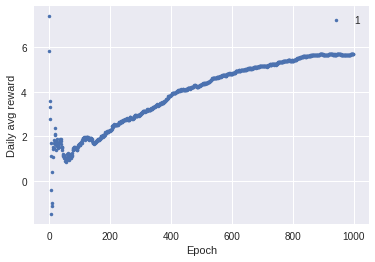

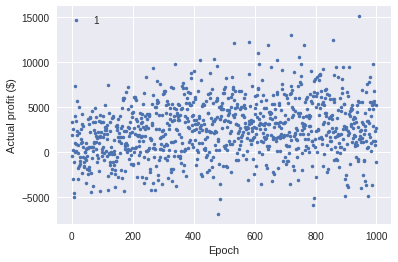

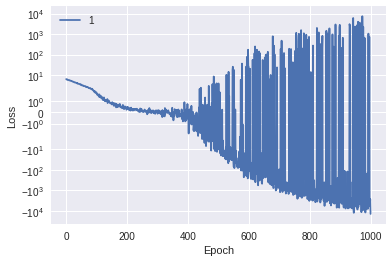

In [0]:
comparison_bl_ac = actual_reward_axis - baseline_axis
network_labels = ['CNN', 'DFF NN']

for i, compare in enumerate(comparison_array):
    plt.figure(0)
    plt.plot(ep_index, daily_avg_reward_axis[i],'.',label=str(compare))
    plt.figure(1)
    plt.plot(ep_index, actual_reward_axis[i],'.', label=str(compare))
    plt.figure(2)
    plt.plot(ep_index, loss_axis[i],'-', label=str(compare))
    
plt.figure(0)
plt.legend()
plt.ylabel('Daily avg reward')
plt.xlabel('Epoch')
plt.savefig('avg.png', dpi=300)

plt.figure(1)
plt.legend()
plt.ylabel('Actual profit ($)')
plt.xlabel('Epoch')
plt.savefig('actual.png', dpi=300)

plt.figure(2)
plt.legend()
plt.yscale('symlog')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('loss.png', dpi=300)

print('bL mean 1/2',np.mean(baseline_axis[i][0:150]),' bL mean 2/2',np.mean(baseline_axis[i][150:]),)
print('bL std 1/2', np.std(baseline_axis[i][0:150]),'bL std 2/2',np.std(baseline_axis[i][150:]),)
print()

for i, compare in enumerate(comparison_array):
    print('mean 1/2',np.mean(actual_reward_axis[i][0:150]),'mean 2/2',np.mean(actual_reward_axis[i][150:]),)
    print('std 1/2', np.std(actual_reward_axis[i][0:150]),'std 2/2',np.std(actual_reward_axis[i][150:]),)
    print()


##Testing

In [0]:
test_eps = 100
training = False
with tf.Session() as sess:
    test_rewards, test_actual_rewards, test_BL_rewards, test_actions = [],[],[],[]
    ep_test_rewards, ep_test_actual_rewards, ep_test_BL_rewards, ep_test_actions = [],[],[],[]
    all_test_rewards, all_test_actual_rewards, all_test_BL_rewards, all_test_actions = [],[],[],[]
    total_test_rewards = []
    train_max_steps = test_rows - 1 - stack_size
    step_index = [i for i in range(train_max_steps)]
    
    
    
    for j, comparison in enumerate(comparison_array):
        # Load the model
        saver.restore(sess,"./models/model" + str(j) + ".ckpt")
        
        for episode in range(test_eps):
            total_rewards = 0;
            step = 0
            prev_action_id = -1
            test_env = Environment(market_dataset = test_data_norm,
                                   stock_prices = train_price_data, 
                                    total_params = global_total_params,
                                    number_of_stocks = number_of_stocks,
                                    current_index = 0,
                                    agent_state = init_agent_state[:],
                                    action_size = global_action_size,
                                    brokerage_fee = brokerage_fee,
                                    stack_size = stack_size)

            test_env.reset(0, init_agent_state[:],2)
    
            state = test_env.get_state()   
            step = 0
            while step < train_max_steps:
                step += 1
                
                agent_state = test_env.get_agent_state() 
                action_id = choose_action(state, agent_state, test_env, training, PGNetwork2)
                action = test_env.actions[action_id]

                # Perform action and get next state
                next_state, disc_reward, act_reward  = test_env.next(action_id)

                if (step == 1):
                    test_rewards.append(disc_reward)
                    test_actual_rewards.append(act_reward)
                    test_BL_rewards.append(test_env.get_reward_baseline())   
                    test_actions.append(action_id)   
                else:
                    test_rewards.append(test_rewards[step - 2] + disc_reward)
                    test_actual_rewards.append(test_actual_rewards[step - 2] + act_reward)
                    test_BL_rewards.append(test_BL_rewards[step - 2] + test_env.get_reward_baseline())
                    test_actions.append(action_id) 

                total_rewards += disc_reward
                state = next_state
            
            if episode % 10 == 0:
                print("stock: ", 0)
                print("Reward: ", total_rewards)
                
                action_probability_distribution = sess.run(PGNetwork2.action_distribution, 
                                                   feed_dict={PGNetwork2.inputs_: state.reshape((1, *state_size)),
                                                             PGNetwork2.agent_inputs : agent_state.reshape((1,2))})
                print(action_id, action_probability_distribution)
                print("==========================================")
            
            ep_test_rewards.append(test_rewards)
            ep_test_actual_rewards.append(test_actual_rewards)
            ep_test_BL_rewards.append(test_BL_rewards)
            ep_test_actions.append(test_actions)
            
            test_rewards, test_actual_rewards, test_BL_rewards, test_actions = [],[],[],[]
            total_rewards = 0
            
        all_test_rewards.append(ep_test_rewards)
        all_test_actual_rewards.append(ep_test_actual_rewards)
        all_test_BL_rewards.append(ep_test_BL_rewards)
        all_test_actions.append(ep_test_actions)
        
        ep_test_rewards, ep_test_actual_rewards, ep_test_BL_rewards, ep_test_actions = [],[],[],[]

INFO:tensorflow:Restoring parameters from ./models/model0.ckpt
stock:  0
Reward:  [3815.34499773]
0 [[0. 1. 0.]]
stock:  0
Reward:  [3815.34499773]
0 [[0. 1. 0.]]
stock:  0
Reward:  [3815.34499773]
0 [[0. 1. 0.]]
stock:  0
Reward:  [3815.34499773]
0 [[0. 1. 0.]]
stock:  0
Reward:  [3815.34499773]
0 [[0. 1. 0.]]
stock:  0
Reward:  [3815.34499773]
0 [[0. 1. 0.]]
stock:  0
Reward:  [3815.34499773]
0 [[0. 1. 0.]]
stock:  0
Reward:  [3815.34499773]
0 [[0. 1. 0.]]
stock:  0
Reward:  [3815.34499773]
0 [[0. 1. 0.]]
stock:  0
Reward:  [3815.34499773]
0 [[0. 1. 0.]]


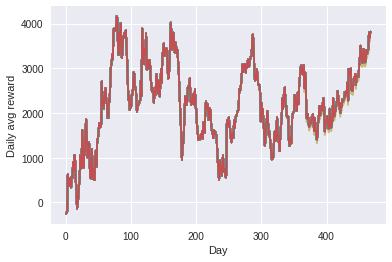

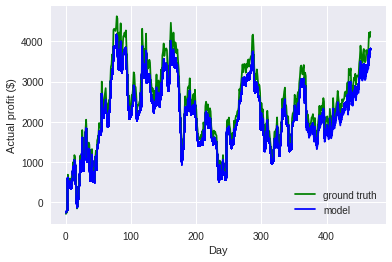

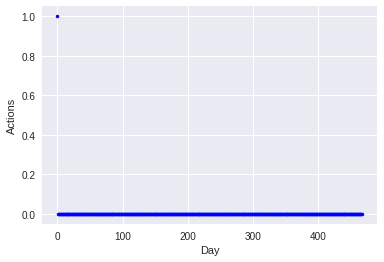

In [0]:
# Plot test results
for i in range(len(comparison_array)):
    for j in range(test_eps - 1):
        plt.figure(3*i)
        plt.plot(step_index,all_test_rewards[i][j],'-')
        plt.figure(3*i + 1)
        plt.plot(step_index, all_test_actual_rewards[i][j], 'b-')
        
    j += 1    
    plt.figure(3*i + 1)
    plt.plot(step_index, all_test_BL_rewards[i][j], 'g-',label='ground truth')
    plt.plot(step_index, all_test_actual_rewards[i][j], 'b-', label='model')
    plt.figure(3*i)
    plt.ylabel('Daily avg reward')
    plt.xlabel('Day')
    plt.savefig('test_discrete_'+str(i)+'.png', dpi=300)
    
    plt.figure(3*i + 1)
    plt.legend()
    plt.ylabel('Actual profit ($)')
    plt.xlabel('Day')
    plt.savefig('test_actual_'+str(i)+'.png', dpi=300)

    plt.figure(3*i + 2)
    plt.plot(step_index,all_test_actions[i][0],'b.')
    plt.ylabel('Actions')
    plt.xlabel('Day')
    plt.savefig('test_actions_'+str(i)+'.png', dpi=300)